<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">22.418 · Aprenentatge automàtic</p>
<p style="margin: 0; text-align:right;">Grau en Ciència de Dades Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Reinforcement learning 2: the lunar lander

## Introduction
In this example we are going to use another RL environment, in this case it is one of the environments included with OpenAI Gym so you will only have to install it if you do not have it already, plus the ```box2d-py``` 2D physics engine. On the other hand, the RL algorithms are provided by package ```keras-rl2```.


In [1]:
!pip install numpy box2d-py gym keras-rl2

     |████████████████████████████████| 450kB 11.5MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 


The environment is the **lunar lander**, where you (the agent) controls a lunar probe that must land in the landing pad, surrounded with flags, as you can see on the image below.

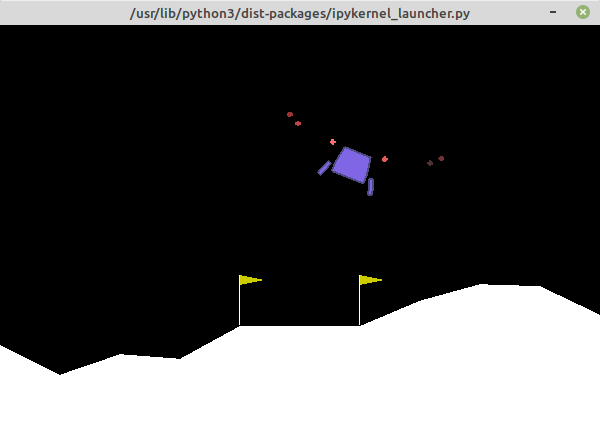



### Actions
The lander has three thrusters: one at the bottom, one at the left side and another one at the right side. It must turn them on and off to get to the right position. It can only turn one of them one at a time, or none, so in total there are four actions available. 

Note that we are using the discrete version here, where the thrusters can only be on or off; there is a continuous version of the lunar lander where the power of the thrusters can be regulated, but continuous action spaces are not directly compatible with deep q-learning.

Although this is the moon, there is a bit of wind here, so the lander will have to compensate for that too.


### Observations
The observations in the Lunar Lander environment have eight values:
- x and y position of the lander (the starting point is 0,0)
- x and y components of the velocity (vector) of the lander
- Angle
- Angular velocity
- Two bools that are true (1.0) if the left or right legs are touching the ground

### Rewards
The highest reward (200) comes from landing on the landing pad. The episode fails if the lander crashes, but it gets some reward if it lands correctly but away from the pad. Each use of the thruster gives a reward of -0.3, in order to encourage an efficient strategy, although the fuel is infinite.

## Trying the environment
We can simply create an environment and run it with random actions to see it working.

***

**NOTE**: Google Colab does not allow to render the environment as it is. In order to run this example in Google Colab, you have two options:

1. Set ```RENDER = False``` so the RL is running and learning but there is no visual output of the result.

2. Try one of the solutions proposed here:
[https://ymd_h.gitlab.io/ymd_blog/posts/gym_on_google_colab_with_gnwrapper/](https://ymd_h.gitlab.io/ymd_blog/posts/gym_on_google_colab_with_gnwrapper/)

In [2]:
import gym

RENDER = False

env = gym.make('LunarLander-v2')

obs = env.reset()

for step in range(500):
    if RENDER:
        env.render()
    env.step(env.action_space.sample())
env.close()    

## Deep Q-learning

The deep Q-learning algorithm, or DQN, uses a neural network to learn an approximation of the Q-function, given that it is impossible to create a Q-table because the number of states is huge. 
For example in this problem the state space is all the combinations of all possible positions, velocities, angles, angular velocities and leg status.

The improvements of DQN over a direct translation of Q-learning to neural networks are mainly two:

1. To avoid training the network with correlated examples, a **replay buffer** is used to store the experience of the agent and to select random examples from it, so that the training examples are **independent and identically distributed**.
2. To avoid the problem of adjusting the weights of the network while adjusting the Q-function itself (the *moving target* problem), **two** networks are used: an **online** network that is constantly updated, and a **target** network that is only updated every *N* iterations. This way the online network has a rather stable reference (the output of the target network) to adjust its weights and biases.

The ```DQNAgent``` class used to solve this environment includes the replay buffer and the double network to create a DQN RL agent that learns how to land the lunar lander.


### Replay buffer

One of the key elements in DQN is the replay buffer, which is basically a list of experiences with a size limit, from which the neural network (NN) will randomly sample mini-batches of training samples during the training process. Consequently, as the agent interacts with the environment, the replay buffer stores:

- The state of the environment (actually, the observations from the environment)
- The action chosen by the agent
- The new state of the environment, after executing the action (again, the observations rather than the state)
- The reward obtained

When the NN trains, a mini-batch of samples from the replay buffer is chosen.


### The neural network
DQN uses two neural networks to learn an approximation of the Q-function. The input to such NNs are the observations that the agent receives from the environment, and the outputs are the expected Q-values of each possible action.

In the Lunar Lander example the observation space is a vector of 8 elements, and there are 4 possible actions, so our NNs will have 8 inputs and 4 outputs. Internally they can have as many layers and units as we decide. This is a relatively simple problem, so we are going to use a NN with three hidden layers of 64, 64 and 32 neurons respectively, plus the output layer with 4 neurons.

*Note*: the ```Flatten``` layer is required to transform the input, that is an array of dimensions (1, 8), to a vector of 8 elements.

In [3]:
import numpy as np
import gym

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# This avoids a Tensorflow warning message
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# keras-rl specific imports: the DQNAgent class, the policy used and the replay buffer
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

RENDER = False

# We need to create the environment to get the number of observations and actions
# and so to define the NN
env = gym.make('LunarLander-v2')

num_obs     = env.observation_space.shape[0]
num_actions = env.action_space.n


# NN model with 3 hidden layers (DQNAgent automatically duplicates this to create
# the online and target NNs)
model = tf.keras.models.Sequential()
model.add(layers.Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_actions, activation='linear'))

Here you can see the structure of the NN model:

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 20,964
Trainable params: 20,964
Non-trainable params: 0
_________________________________________________________________


### The DQN Agent

The next step is to create the DQNAgent. It needs the following objects:
- The NN model, created above
- The number of actions of the environment (4)
- The replay buffer, which is a sequential buffer (older elements are deleted when the maximum size is reached) with a maximum size of 50000
- ```nb_steps_warmup```: as in the first RL steps the errors in the NN are very high, the learning rate is reduced until some stability is reached, so the first steps are less influential
- ```target_model_update```: the online NN is continuously updating its weights, but the target NN only updates its weights (copying those from the online NN) from time to time; this parameter controls the probability of update of the target NN
- The policy update equation (Boltzmann Q policy)


The outputs of the NN are real values, so it is similar to a regression problem, with as many output variables as actions in the environment. Consequently, the output layer has linear activation and the loss function is the mean squared error (```mse```), set internally in class DQNAgent.

As with any NN in Tensorflow/Keras, it has to be compiled, setting the optimizer algorithm to ```Adam``` with a learning rate ```lr=1e-3```.

In [5]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()

dqn = DQNAgent(model=model, nb_actions=num_actions, memory=memory, nb_steps_warmup=100,
               target_model_update=1e-2, policy=policy)

dqn.compile(optimizers.Adam(lr=1e-3))

### Training the agent

Finally the agent has to be trained. Class DQNAgent does the training with method ```fit()```, which internally performs the following steps:

1. Run the environment, letting the agent choose the action following an epsilon-greedy policy
2. Store the experience acquired (state, action chosen, reward, new state, and if the episode is finished) on each RL step into the replay buffer
3. Train the **online** NN using a random mini-batch from the replay buffer (every n steps)
4. Copy the weights from the online NN to the **target** NN every p << n steps
5. Go back to 1 until the maximum number of RL steps have been executed

As with the standard ```fit()``` from Keras, the training history is returned so we can visualize the learning process afterwards.

In [6]:
history = dqn.fit(env, nb_steps=100000, visualize=RENDER)

Training for 100000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10000/10000 [==============================] - 87s 9ms/step - reward: -0.2989
29 episodes - episode_reward: -101.769 [-409.359, 162.963] - loss: 5.929 - mean_q: 6.310

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -0.0391
27 episodes - episode_reward: -15.650 [-212.277, 239.653] - loss: 5.924 - mean_q: 35.291

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: 0.1105
14 episodes - episode_reward: 77.643 [-61.085, 196.488] - loss: 6.571 - mean_q: 46.478

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 89s 9ms/step - reward: 0.1281
10 episodes - episode_reward: 128.853 [71.478, 178.107] - loss: 5.241 - mean_q: 46.247

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: 0.1201
11 episodes - episode_reward: 98.312 [-47.369, 154.511] - loss: 5.677 - mean_q: 44.303

Interval 6 (50000 steps perfo

As the training process can take some time, it is a good idea to save the trained model so that it can be loaded either for further training or for using it to solve the environment. The **h5f** format is a standard file format to save neural networks.

In [7]:
dqn.save_weights('dqn_{}_weights.h5f'.format('lunar_lander'), overwrite=True)

### Running the environment

Once trained, the DQN agent can be readily used to run the environment, using the **target** NN in its current state. The lander efficiently solves the problem in most cases, getting a very good reward (>200) in general. On some episodes the reward can be lower, while the number of steps is much higher. This means that the lander has been flying around for longer, which is a less efficient solution, or the lander has crashed.

In [8]:
dqn.test(env, nb_episodes=5, visualize=RENDER)

Testing for 5 episodes ...
Episode 1: reward: -307.235, steps: 421
Episode 2: reward: 221.947, steps: 267
Episode 3: reward: 259.762, steps: 231
Episode 4: reward: 234.563, steps: 287
Episode 5: reward: 278.867, steps: 208


### Visualizing the learning process

The learning curves are one of the most useful tools to understand the learning process in any neural network model, as well as to detect any learning problems that need solution. As the ```fit()``` method returns the history of the training process, it is straightforward to plot the curves as follows.

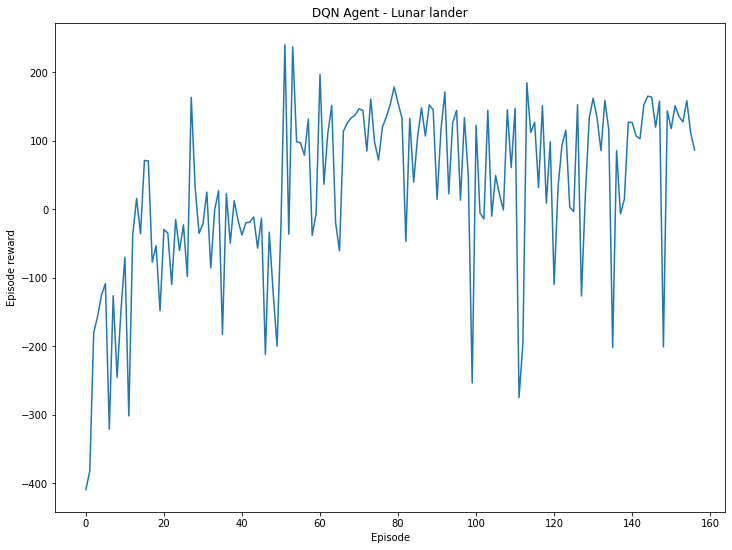

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,9))
ax.plot(history.history['episode_reward'])
ax.set_title('DQN Agent - Lunar lander')
ax.set_ylabel('Episode reward')
ax.set_xlabel('Episode')
plt.show()

In the previous plot we can see the reward per episode. In general it improves with training, although still in some episodes it fails or performs worse. 



The number of steps required to complete each episode is also an interesting piece of information.
- A number of steps too low may mean that the agent has crashed.
- An intermediate number of steps seems ideal: efficient landing.
- Too many steps may be a sign that the agent is flying around without landing.

On the next plot we can see that the agent learns to fly, then very often it simply keeps flying because that way it avoids crashing (highest penalty), even if it does not get the maximum reward for landing.

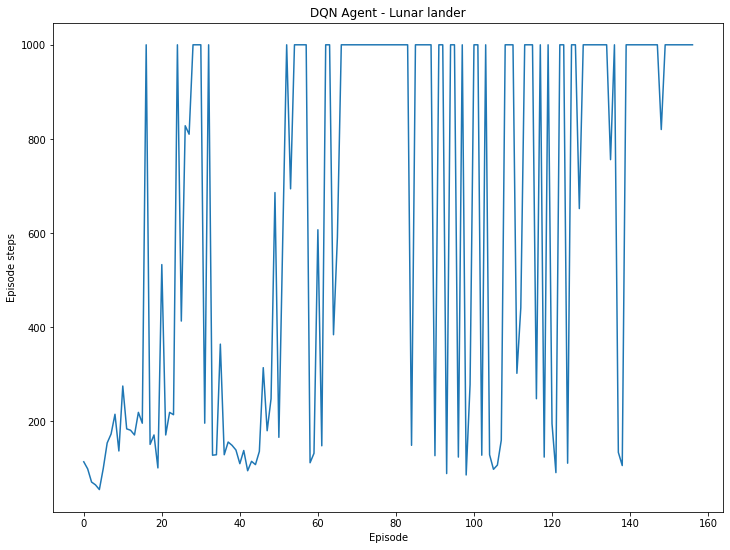

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,9))
ax.plot(history.history['nb_episode_steps'])
ax.set_title('DQN Agent - Lunar lander')
ax.set_ylabel('Episode steps')
ax.set_xlabel('Episode')
plt.show()

# Activities

The previous example has shown how to train a DQN agent to solve a task. There are many options and alternative ways to solve this problem. The activities proposed here suggest some changes or experiments that you can try to explore different solutions.

- **Neural network**: change the NN model. Try to solve the problem with a very simple NN, for example one with an input layer of 4 neurons, then the output layer. Is it able to solve the task? 
- **Neural network**: now try with a much more complex NN model, for example one with layers of width 512/256/128/64/32. Does it perform better? How much is the training time increased? Is it worth it (on this problem)?
- **Learning steps**: according to the number of steps per episode plot seen before, it may be interesting to stop the training around episode 60, where the number of steps seems optimal. Try it. What happens with the reward per episode? Is it worth stopping training? And training more?
- **Replay buffer**: here we have used a replay buffer of size 50000. What happens if you reduce it to size 5000? Is it better or worse?
